#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
Значение метрики RMSE на тестовой выборке должно быть не больше 48.


## Подготовка

Загрузка данныъ и их ресемплирование по одному часу.

In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.isna().sum()

num_orders    0
dtype: int64

In [4]:
df[df['num_orders'].isna() == True]

,num_orders
datetime,


In [5]:
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
df.index.is_monotonic_increasing

True

Пропусков нет, последовательность соблюдается

Данные на 2018 год за 6 месяцев

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
df = df.resample('1H').sum()

In [9]:
decomposed = seasonal_decompose(df) 

Text(0.5, 1.0, 'resid')

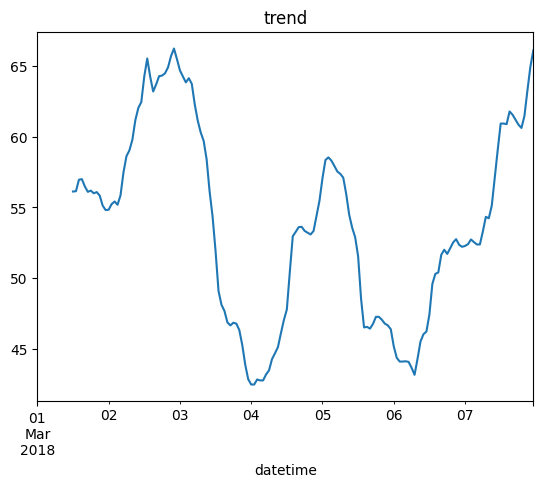

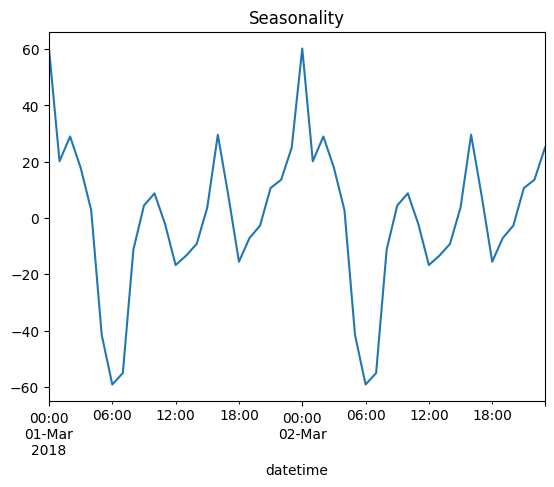

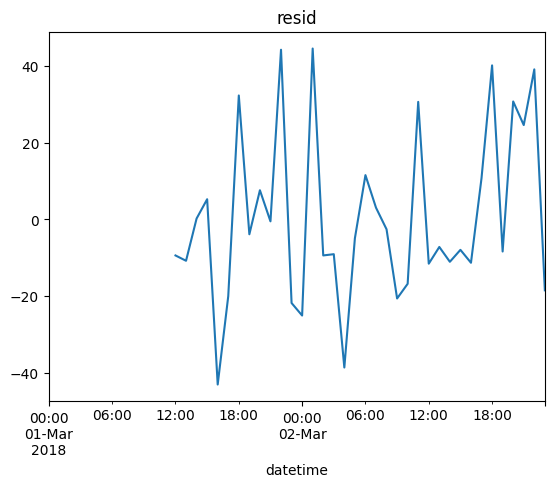

In [10]:
plt.figure()

plt.subplot()
decomposed.trend['2018-03-01':'2018-03-7'].plot(ax=plt.gca())
plt.title('trend')

plt.figure()
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.figure()
decomposed.resid['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('resid')

 По тренду видны скачки в течение недели, что логично -- 1 марта 2018 года это четверг, на пятницу и субботу приходится много вызовов, люди веселятся. В воскресенье минимум, все отдыхают дома. В рабочие дни вызовов меньше, ну и к праздникам снова повышение\
Сезонность в сутки тоже понятна, минимум вызовов в 6 утра, когда все либо уже спят, либо еще не проснулись. Пик ночью, когда людям нужно вернуться домой, а общественнывй транспорт уже не работает.


In [11]:
df['Hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

In [12]:
def make_features(data, max_lag, rolling_mean_size): 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
def rmse(t, p):
    return mean_squared_error(t, p) ** 0.5
scorer = make_scorer(rmse, greater_is_better=False)

Проверка разных окон и сдвигов:

In [ ]:
make_features(df, 168, 33)

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [21]:
model = LinearRegression()
model.fit(features_train, target_train)
rmse(target_test, model.predict(features_test))

35.268041584598016

## Обучение

In [22]:
def test_rmse(model):
    model = model
    model.fit(features_train, target_train)
    print("RMSE обучающей выборки:", rmse(target_train, model.predict(features_train)).round(2))
    print("RMSE тестовой выборки: ", rmse(target_test, model.predict(features_test)).round(2))

Начнем с dummy моделей
### Dummy

По среднему

In [23]:
pred = pd.Series([train['num_orders'].mean()] * len(target_test))
print("RMSE:", rmse(target_test, pred))

RMSE: 83.97941361168559


По медиане

In [24]:
pred = pd.Series([train['num_orders'].median()] * len(target_test))
print("RMSE:", rmse(target_test, pred).round(2))

RMSE: 86.41


По предыдущему

In [25]:
pred_previous = target_test.shift(fill_value=float(target_train.iloc[-1:]))
print("RMSE:", rmse(target_test, pred_previous).round(2))

RMSE: 58.86


C:\Users\Мария\AppData\Local\Temp\ipykernel_5488\3846609362.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pred_previous = target_test.shift(fill_value=float(target_train.iloc[-1:]))


### Линейная

In [26]:
test_rmse(LinearRegression())

RMSE обучающей выборки: 20.72
RMSE тестовой выборки:  35.27


In [27]:
results = pd.DataFrame({
    'model' : [],
    'rmse' : []
})

In [28]:
model = LinearRegression()
rmse_count = cross_val_score(model,
                features_train, 
                target_train, 
                cv = TimeSeriesSplit(n_splits=8), 
                n_jobs = -1, 
                scoring = 'neg_root_mean_squared_error').mean() * (-1)
rmse_count

22.948398873270744

In [29]:
results.loc[0, 'model'] = 'LinearRegression'
results.loc[0, 'rmse'] = rmse_count.round(2)

### LGBM

In [30]:
parametrs = {'n_estimators': range(90, 120, 10),
             'learning_rate': np.arange(0.05, 0.26, 0.5),
             'num_leaves': range(25, 41, 2)
             }

Подбор лучших параметров

In [31]:
# %%time
# model_LGBM = LGBMRegressor()
# grid = GridSearchCV(model_LGBM, parametrs, cv=5, verbose=50, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

In [32]:
%%time
model_LGBM = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_LGBM,
                       param_grid=parametrs,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=10)
grid.fit(features_train, target_train)
grid.best_score_

Fitting 8 folds for each of 24 candidates, totalling 192 fits
CPU times: total: 19 s
Wall time: 1min 2s


-22.307695041715505

In [33]:
results.loc[1, 'model'] = 'LGBMRegressor'
results.loc[1, 'rmse'] = (grid.best_score_*(-1)).round(2)

{'learning_rate': 0.05, 'n_estimators': 110, 'num_leaves': 27}

In [34]:
test_rmse(LGBMRegressor(learning_rate=0.05, n_estimators=110, num_leaves=27))

RMSE обучающей выборки: 13.26
RMSE тестовой выборки:  36.81


### Cat

In [35]:
parametrs = {'iterations': range(10, 40, 5),
             'learning_rate': np.arange(0.01, 0.7, 0.05),
             }

In [36]:
%%time
model_cat = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_cat,
                       param_grid=parametrs,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=10)
grid.fit(features_train, target_train)
grid.best_score_

Fitting 8 folds for each of 84 candidates, totalling 672 fits
0:	learn: 35.4688803	total: 146ms	remaining: 4.98s
1:	learn: 32.5498787	total: 161ms	remaining: 2.65s
2:	learn: 30.4059762	total: 178ms	remaining: 1.9s
3:	learn: 28.4559366	total: 195ms	remaining: 1.51s
4:	learn: 26.9236192	total: 209ms	remaining: 1.25s
5:	learn: 25.8066931	total: 225ms	remaining: 1.09s
6:	learn: 24.7804533	total: 243ms	remaining: 973ms
7:	learn: 23.9654204	total: 257ms	remaining: 868ms
8:	learn: 23.3240967	total: 272ms	remaining: 786ms
9:	learn: 22.7811842	total: 286ms	remaining: 716ms
10:	learn: 22.4059337	total: 302ms	remaining: 658ms
11:	learn: 22.0149111	total: 322ms	remaining: 617ms
12:	learn: 21.6981321	total: 335ms	remaining: 568ms
13:	learn: 21.4258066	total: 353ms	remaining: 529ms
14:	learn: 21.1836661	total: 369ms	remaining: 491ms
15:	learn: 21.0030937	total: 384ms	remaining: 456ms
16:	learn: 20.8112642	total: 400ms	remaining: 423ms
17:	learn: 20.6661947	total: 414ms	remaining: 391ms
18:	learn: 20

-22.349374213790973

In [37]:
# %%time
# model_cat = CatBoostRegressor()
# grid = GridSearchCV(model_cat, parametrs, cv=5, verbose=2, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

In [38]:
results.loc[2, 'model'] = 'CatBoostRegressor'
results.loc[2, 'rmse'] = (grid.best_score_ * (-1)).round(2)

{'iterations': 35, 'learning_rate': 0.16}

In [39]:
test_rmse(CatBoostRegressor(iterations=35, learning_rate=0.21))

0:	learn: 34.5243762	total: 15.4ms	remaining: 522ms
1:	learn: 30.9747584	total: 29.4ms	remaining: 485ms
2:	learn: 28.5877708	total: 43.8ms	remaining: 467ms
3:	learn: 26.5880054	total: 58.1ms	remaining: 451ms
4:	learn: 25.0209212	total: 73.2ms	remaining: 439ms
5:	learn: 24.0037336	total: 87.5ms	remaining: 423ms
6:	learn: 23.1382822	total: 101ms	remaining: 405ms
7:	learn: 22.4665188	total: 115ms	remaining: 388ms
8:	learn: 21.9650481	total: 129ms	remaining: 372ms
9:	learn: 21.6069819	total: 143ms	remaining: 358ms
10:	learn: 21.2854717	total: 157ms	remaining: 342ms
11:	learn: 20.9829874	total: 172ms	remaining: 329ms
12:	learn: 20.7341962	total: 187ms	remaining: 317ms
13:	learn: 20.5136935	total: 202ms	remaining: 303ms
14:	learn: 20.3664654	total: 216ms	remaining: 288ms
15:	learn: 20.2021452	total: 231ms	remaining: 274ms
16:	learn: 20.0871738	total: 245ms	remaining: 259ms
17:	learn: 19.9172008	total: 259ms	remaining: 244ms
18:	learn: 19.8900007	total: 273ms	remaining: 230ms
19:	learn: 19.78

### Tree

In [40]:
parametrs = {'max_depth': range(3, 11, 2),
             'min_samples_leaf': range(4, 8),
             'min_samples_split': range(2, 6, 2)
             }

In [41]:
%%time
model_tree = DecisionTreeRegressor(random_state=0)
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_tree,
                       param_grid=parametrs,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=10)
grid.fit(features_train, target_train)
grid.best_score_

Fitting 8 folds for each of 32 candidates, totalling 256 fits
CPU times: total: 4.47 s
Wall time: 9.38 s


-25.26052468309368

In [42]:
# %%time
# model_tree = DecisionTreeRegressor(random_state=0)
# grid = GridSearchCV(model_tree, parametrs, cv=5, verbose=10, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

In [43]:
results.loc[3, 'model'] = 'DecisionTreeRegressor'
results.loc[3, 'rmse'] = (grid.best_score_ * (-1)).round(2)

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [44]:
test_rmse(DecisionTreeRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=2))

RMSE обучающей выборки: 21.74
RMSE тестовой выборки:  45.22


## Проверка и выводы

In [45]:
results

,model,rmse
0,LinearRegression,22.95
1,LGBMRegressor,22.31
2,CatBoostRegressor,22.35
3,DecisionTreeRegressor,25.26


В итоге все модели кроме леса почти на одном уровне

In [46]:
model = LGBMRegressor(learning_rate=0.05, n_estimators=110, num_leaves=27)
test_rmse(model)

RMSE обучающей выборки: 13.26
RMSE тестовой выборки:  36.81


In [47]:
pred = pd.DataFrame(model.predict(features_test), index = target_test.index)

Text(0.5, 1.0, 'Сравнение модели и реальных данных за 2 дня')

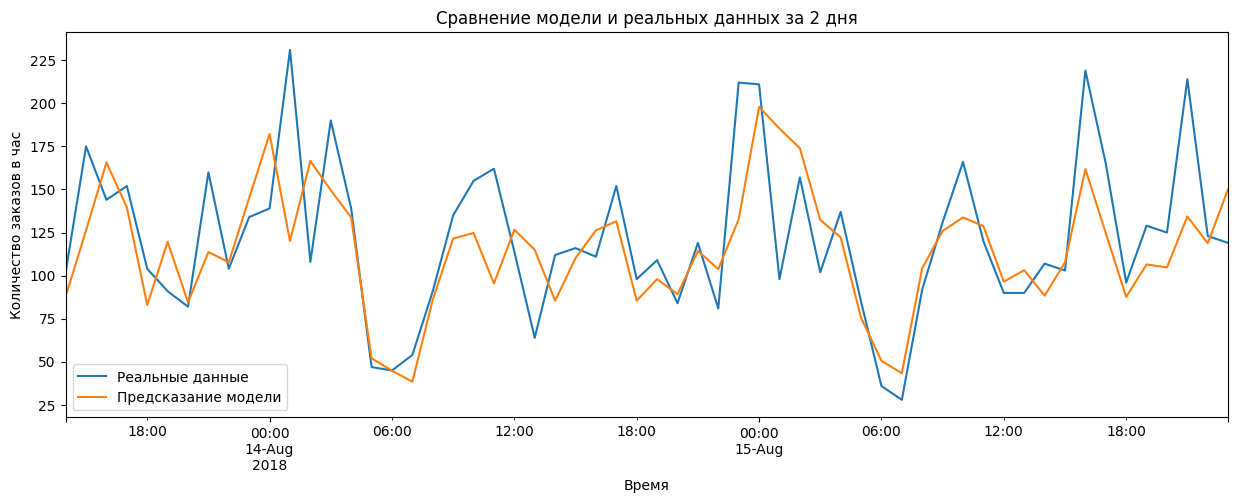

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot()

target_test['2018-08-13':'2018-08-15'].plot(ax=plt.gca(), label='Реальные данные')
pred['2018-08-13':'2018-08-15'].plot(ax=plt.gca(), label='Предсказание модели')

plt.legend(['Реальные данные', 'Предсказание модели'])
plt.xlabel('Время')
plt.ylabel('Количество заказов в час')

plt.title('Сравнение модели и реальных данных за 2 дня')

**По графику видно, что модель хорошо справляется с предсказанием, точно устанавливая места максимумов и минимумов на графике, и незначительно ошибается в самом значении**